#### Load Spark

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Exploring the Dataset

In [6]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from pyspark.sql.functions import count, desc, avg, explode, split, col
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

In [7]:
# Downloading and preprocessing IMDB dataset and other related datasets
df = spark.read.csv('/content/drive/MyDrive/MSBA/IMDB_dataset.csv', header=True, sep=",",inferSchema=True)
ImdbTitle = spark.read.csv('/content/drive/MyDrive/MSBA/ImdbTitleBasics.csv', header=True)

####Filtering the dataset with titles with runtime for 5 mins and more, produced from 1950 till now and with 1000 votes and more.

In [8]:
#filtering the data
filtered_df = df.filter(col('runtime') >= 5)
filtered_df = filtered_df.filter(col('startYear') >= 1950)
filtered_df = filtered_df.filter(col('numVotes') >= 1000)

# Drop duplicate rows based on all columns
df = filtered_df.dropDuplicates()

In [9]:
#getting the number of rows and columns
num_rows = df.count()
num_cols = len(df.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

Number of rows:  11734
Number of columns:  9


In [10]:
# Renaming columns
ImdbTitle = ImdbTitle.withColumnRenamed('tconst', 'title_id')
# Drop non useful columns from the DataFrame
ImdbTitle = ImdbTitle.drop('titleType', 'originalTitle','isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres')

In [11]:
# Identify the join key in the second DataFrame
join_key = 'title_id'

# Join the two DataFrames on the join key
df = df.join(ImdbTitle, on=join_key, how='inner')

In [12]:
# Show the resulting DataFrame
df.show()

+---------+----------+---------+-------+--------------------+--------------------+--------------------+-------------+--------+--------------------+
| title_id|title_type|startYear|runtime|               genre|           directors|              actors|averageRating|numVotes|        primaryTitle|
+---------+----------+---------+-------+--------------------+--------------------+--------------------+-------------+--------+--------------------+
|tt0035423|     movie|     2001|    118|Comedy-Fantasy-Ro...|           nm0003506|nm0000212-nm04131...|  6.400000095|   79396|      Kate & Leopold|
|tt0038687|     movie|     1980|     58|     Documentary-War|           nm0001379|           nm0404158|  7.400000095|    1654|  Let There Be Light|
|tt0041387|     movie|     1950|     91| Comedy-Drama-Family|           nm0523893|nm0640307-nm05757...|          6.5|    1148|             Francis|
|tt0041694|     movie|     1950|     98|     Drama-Film-Noir|           nm0500552|nm0001766-nm05261...|  7.40000

### Exploring Titles

####Years with most titles in the dataset

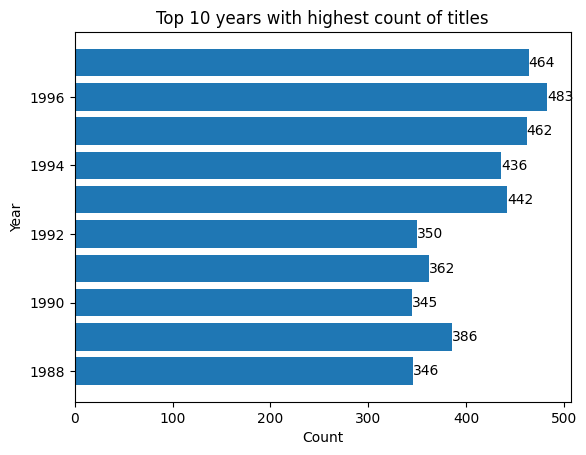

In [13]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc

# group the DataFrame by startYear and count the number of title_id values for each startYear
year_counts = df.groupBy("startYear").agg({"title_id": "count"})

# sort the DataFrame by the count of title_id values in descending order
sorted_year_counts = year_counts.sort(desc("count(title_id)"))

# select the top 10 start years with the highest count of title_id values
top_years = sorted_year_counts.limit(10)

# extract the startYear and count values as lists
years = [row.startYear for row in top_years.collect()]
counts = [row["count(title_id)"] for row in top_years.collect()]

# plot the counts for the top 10 years in descending order
fig, ax = plt.subplots()
rects = ax.barh(years[::-1], counts[::-1])
ax.set_xlabel("Count")
ax.set_ylabel("Year")
ax.set_title("Top 10 years with highest count of titles")

# add text labels to the bars
for i, rect in enumerate(rects):
    ax.text(rect.get_width(), rect.get_y() + rect.get_height()/2, str(counts[::-1][i]), ha='left', va='center')

plt.show()


Through the succession of years, title production has been on an increase reaching its peak in 1996 with 483 titles, a 40% increase from only 6 years before that when 345 titles were made.

####Top 100 titles by rating by Years

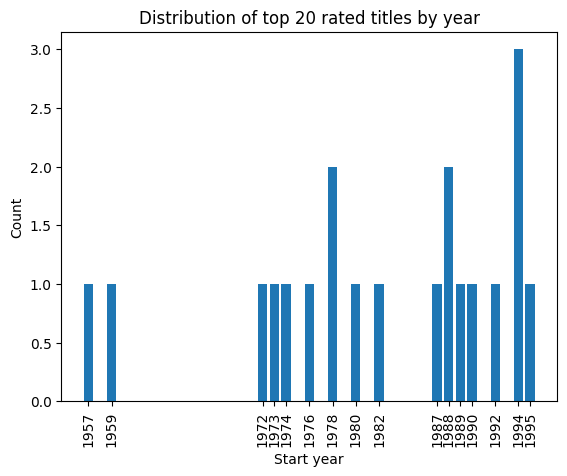

In [14]:
# select the top 100 titles by average rating
top_titles = df.orderBy(desc("averageRating")).limit(20)

# group the top 100 titles by startYear and count the number of titles for each startYear
year_counts = top_titles.groupBy("startYear").agg({"title_id": "count"})

# sort the DataFrame by the startYear in ascending order
sorted_year_counts = year_counts.sort("startYear")

# extract the startYear and count values as lists
years = [row.startYear for row in sorted_year_counts.collect()]
counts = [row["count(title_id)"] for row in sorted_year_counts.collect()]

# plot the counts for the top 100 titles by year
fig, ax = plt.subplots()
ax.bar(years, counts)
ax.set_xlabel("Start year")
ax.set_ylabel("Count")
ax.set_title("Distribution of top 20 rated titles by year")

# set the x-tick positions and labels to the startYear values
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=90)

plt.show()

Off the top 20 highest rated titles in the last 70 years, 1994 has 3 of them, followed by 1978 and 1988 with 2 titles. The most interesting part is that no titles in the last 30 years have entered the top 20 list.

####The runtime of the movies with the average rating through the years

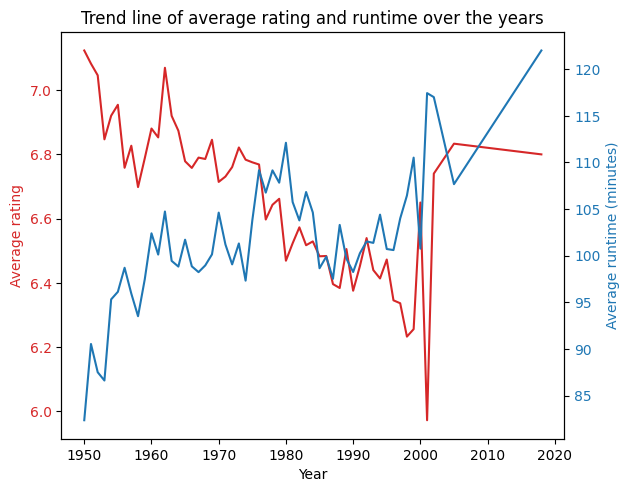

In [15]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg

# assume we have a DataFrame `df` with the columns you listed

# group the DataFrame by startYear and compute the average runtime and average rating for each year
year_stats = df.groupBy("startYear").agg(avg("runtime").alias("avg_runtime"), avg("averageRating").alias("avg_rating"))

# sort the DataFrame by startYear in ascending order
sorted_year_stats = year_stats.sort("startYear")

# extract the startYear, avg_runtime and avg_rating values as lists
years = [row.startYear for row in sorted_year_stats.collect()]
avg_runtimes = [row.avg_runtime for row in sorted_year_stats.collect()]
avg_ratings = [row.avg_rating for row in sorted_year_stats.collect()]

# plot the trend line series of average runtime and average rating
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average rating', color=color)
ax1.plot(years, avg_ratings, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Average runtime (minutes)', color=color)  # we already handled the x-label with ax1
ax2.plot(years, avg_runtimes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Trend line of average rating and runtime over the years')
plt.show()


More minutes doesn't mean higher rating. Through the years, the runtime of titles has immensly increased but on the other hand ratings have seen a decrease on average. Runtime might not be the cause of it as many titles were made which might have affected the average rating. It's only in the last 20 years that ratings have reach a steady value with the increase of runtime.

####Highest rated combination of genres

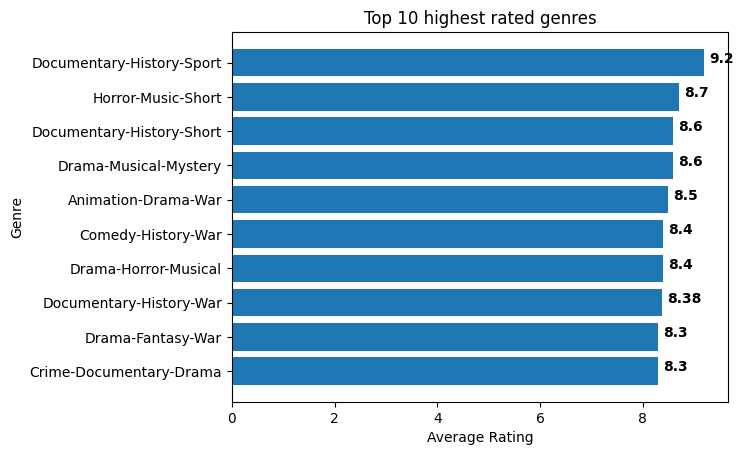

In [16]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc

# assume we have a DataFrame `df` with the columns you listed

# group the DataFrame by genre and compute the average rating for each genre
genre_ratings = df.groupBy("genre").agg({"averageRating": "mean"})

# sort the DataFrame by the average rating in descending order
sorted_genre_ratings = genre_ratings.orderBy(desc("avg(averageRating)"))

# select the top 10 genres with the highest average rating
top_genres = sorted_genre_ratings.limit(10)

# extract the genre and avg_rating values as lists
genres = [row.genre for row in top_genres.collect()]
avg_ratings = [row["avg(averageRating)"] for row in top_genres.collect()]

# plot the horizontal bar chart of the top 10 highest rated genres with labels
fig, ax = plt.subplots()
bar_plot = ax.barh(genres[::-1], avg_ratings[::-1])
ax.set_xlabel("Average Rating")
ax.set_ylabel("Genre")
ax.set_title("Top 10 highest rated genres")

# add the rating values as labels to the bars
for i, v in enumerate(avg_ratings[::-1]):
    ax.text(v + 0.1, i, str(round(v, 2)), color='black', fontweight='bold')

plt.show()


A historic documentary is the way to go if a producer is seeking a highly rated title. More precisely historic documentaries about sport and war, and also those who are short. In addition Short horrors have taken a surprising second place, while dramatic musical mysteries complete the top 4.

### Movie Recommendation System using KMeans

####Loading Data

In [17]:
df = spark.read.csv('/content/drive/MyDrive/MSBA/IMDB_dataset.csv', header=True, sep=",",inferSchema=True)
ImdbTitle = spark.read.csv('/content/drive/MyDrive/MSBA/ImdbTitleBasics.csv', header=True)

#### Filtering the years, numVotes and runtime

In [18]:
# Subset the DataFrame with "year" column values starting from 1950
df = df.filter(df["startYear"] >= 1950)
df = df.filter(df["numVotes"] >= 1000)
df = df.filter(df["runtime"] >= 20)

#### Exploding directors, actors and genres

In [19]:
# Split the directors column by "-"
split_col = split(df["directors"], "-")
df = df.withColumn("directors", split_col)

# Explode the directors column
df = df.select("*", explode("directors").alias("director"))

# Drop the original directors column and keep the exploded director column
df = df.drop("directors").withColumnRenamed("director", "directors")

# Split the actors column by "-"
split_col = split(df["actors"], "-")
df = df.withColumn("actors", split_col)

# Explode the actors column
df = df.select("*", explode("actors").alias("actor"))

# Drop the original actors column and keep the exploded actor column
df = df.drop("actors").withColumnRenamed("actor", "actors")

# Split the genre column by "-"
split_col = split(df["genre"], "-")
df = df.withColumn("genre", split_col)

# Explode the genre column
df = df.select("*", explode("genre").alias("genre_type"))

# Drop the original genre column and keep the exploded genre_type column
df = df.drop("genre").withColumnRenamed("genre_type", "genre")


df = df.drop("title_type")

# Show the resulting dataframe
df.show()

+---------+---------+-------+-------------+--------+---------+---------+-----------+
| title_id|startYear|runtime|averageRating|numVotes|directors|   actors|      genre|
+---------+---------+-------+-------------+--------+---------+---------+-----------+
|tt0035423|     2001|    118|  6.400000095|   79396|nm0003506|nm0000212|     Comedy|
|tt0035423|     2001|    118|  6.400000095|   79396|nm0003506|nm0000212|    Fantasy|
|tt0035423|     2001|    118|  6.400000095|   79396|nm0003506|nm0000212|    Romance|
|tt0035423|     2001|    118|  6.400000095|   79396|nm0003506|nm0413168|     Comedy|
|tt0035423|     2001|    118|  6.400000095|   79396|nm0003506|nm0413168|    Fantasy|
|tt0035423|     2001|    118|  6.400000095|   79396|nm0003506|nm0413168|    Romance|
|tt0035423|     2001|    118|  6.400000095|   79396|nm0003506|nm0000630|     Comedy|
|tt0035423|     2001|    118|  6.400000095|   79396|nm0003506|nm0000630|    Fantasy|
|tt0035423|     2001|    118|  6.400000095|   79396|nm0003506|nm0

#### Dropping Duplicates

In [20]:
# Drop duplicate rows based on all columns
df = df.dropDuplicates()

#### Encoding categorical columns and nomralizing numerical columns

In [22]:
# Apply one-hot encoding to the "genre" column
genre_indexer = StringIndexer(inputCol="genre", outputCol="genre_index")
genre_indexed = genre_indexer.fit(df).transform(df)
genre_encoder = OneHotEncoder(inputCols=["genre_index"], outputCols=["genre_vec"])
genre_encoded = genre_encoder.fit(genre_indexed).transform(genre_indexed)

# Apply one-hot encoding to the "directors" column
directors_indexer = StringIndexer(inputCol="directors", outputCol="directors_index")
directors_indexed = directors_indexer.fit(genre_encoded).transform(genre_encoded)
directors_encoder = OneHotEncoder(inputCols=["directors_index"], outputCols=["directors_vec"])
directors_encoded = directors_encoder.fit(directors_indexed).transform(directors_indexed)

# Apply one-hot encoding to the "actors" column
actors_indexer = StringIndexer(inputCol="actors", outputCol="actors_index")
actors_indexed = actors_indexer.fit(directors_encoded).transform(directors_encoded)
actors_encoder = OneHotEncoder(inputCols=["actors_index"], outputCols=["actors_vec"])
actors_encoded = actors_encoder.fit(actors_indexed).transform(actors_indexed)

# Convert numerical columns to float type
cols_to_convert = ["startYear", "runtime", "averageRating", "numVotes"]
for col in cols_to_convert:
    actors_encoded = actors_encoded.withColumn(col, actors_encoded[col].cast("float"))

# Drop the original "genre", "directors", and "actors" columns
final_df = actors_encoded.drop("genre", "directors", "actors")

# Normalize the numerical columns using MinMaxScaler
assembler = VectorAssembler(inputCols=cols_to_convert, outputCol="features")
assembled_df = assembler.transform(final_df)
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

scaled_df = scaled_df.drop("startYear", "runtime", "averageRating", "numVotes")

# Concatenate the binary and numerical features
final_cols = scaled_df.columns[1:-2] + ["genre_vec", "directors_vec", "actors_vec", "scaled_features"]
final_assembler = VectorAssembler(inputCols=final_cols, outputCol="final_features")
final_df = final_assembler.transform(scaled_df)

#### Dropping all columns except the final features

In [23]:
# Select one column and drop all others
final_df = final_df.drop("genre_index", "genre_vec", "directors_index", "directors_vec", "actors_index", "actors_vec", "features", "scaled_features")

#### Using KMeans to cluster the titles

In [ ]:
# Split the data into training and testing sets
train_data, test_data = final_df.randomSplit([0.7, 0.3], seed=42)

# Train the KMeans model
kmeans = KMeans(featuresCol="final_features", k=6, seed=42)
kmeans_model = kmeans.fit(train_data)

# Make predictions on the entire dataset
final_predictions = kmeans_model.transform(final_df)

#### Creating a function to give recommendations based on the watched movie

In [25]:
def recommend_movies(title_id, num_recommendations=5):
    # Find the cluster for the given title_id
    movie_cluster = final_predictions.filter(final_predictions['title_id'] == title_id).select('prediction').collect()[0][0]
    
    # Get the movies in the same cluster
    movies_in_cluster = final_predictions.filter(final_predictions['prediction'] == movie_cluster)
    
    # Remove the input movie from the recommendations
    movies_in_cluster = movies_in_cluster.filter(movies_in_cluster['title_id'] != title_id)
    
    # Randomly sample num_recommendations movies from the cluster
    recommended_movies = movies_in_cluster.sample(withReplacement=False, fraction=1.0, seed=42).limit(num_recommendations)
    
    return recommended_movies.select('title_id').collect()

#### Loading the model trained

In [26]:
# load the saved model from a directory
loaded_model = KMeansModel.load("/content/drive/My Drive/my_model3")

# use the loaded model for prediction
final_predictions = loaded_model.transform(final_df)

#Dropping duplicates from the final predictions
final_predictions = final_predictions.dropDuplicates()

#### Getting the names of the clustered movies

In [27]:
# rename the "id" column to "user_id" and the "name" column to "user_name"
ImdbTitle = ImdbTitle.withColumnRenamed("tconst", "title_id").withColumnRenamed("primaryTitle", "Name")

# create a table from titles
ImdbTitle = ImdbTitle.select("title_id", "Name")
titles_names = final_predictions.join(ImdbTitle, on="title_id", how="left")
titles_names = titles_names.select("title_id", "Name")
titles_names = titles_names.dropDuplicates()

#### Testing the model

##### Create a function to check if the user used a title id or a title name

In [60]:
def get_recommendations(title, id=True):
    # Determine whether to search by title_id or name
    if id:
        search_col = "title_id"
        name = titles_names.filter(titles_names.title_id == title).select("Name").collect()[0]["Name"]
    else:
        search_col = "Name"
        name = title
    
    # Get the recommended movies
    sample_title_id = title if id else titles_names.filter(titles_names.Name == title).select("title_id").collect()[0]["title_id"]
    recommendations = recommend_movies(sample_title_id, 10)
    recommendations = spark.createDataFrame(recommendations)
    
    # Join title_name and recommendations tables on title_id
    joined_df = titles_names.join(recommendations, ["title_id"], "inner")

    # Select the Name column
    result_df = joined_df.select("Name")

    # drop duplicates
    result_df = result_df.dropDuplicates()

    # collect the names of the recommended titles
    titles = result_df.select("Name").collect()

    return name, titles

#### Test cases

In [66]:
# Example with title name
title_name = "Titanic"
name, titles = get_recommendations(title_name, id=False)
print(f"Recommended movies for '{name}':")
for row in titles:
  movies = row.Name
  print(movies)

Recommended movies for 'Titanic':
The Life and Times of Grizzly Adams
Captain Scarlet and the Mysterons
Reilly: Ace of Spies
Robin Hood
Friday the 13th: The Series
Aladdin
Baby's Day Out
The Mad Adventures of Rabbi Jacob
The Man Called Flintstone
Evening Shade


In [71]:
# Example with title id
title_name = "tt0057261"
name, titles = get_recommendations(title_name, id=True)
print(f"Recommended movies for '{name}':")
for row in titles:
  movies = row.Name
  print(movies)

Recommended movies for 'Lord of the Flies':
Godzilla vs. Mechagodzilla
Master of the World
Dementia 13
Flesh Gordon
The Guyver
The Canterbury Tales
Last Tango in Paris
THX 1138
Project X
The City of Lost Children
